In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from src.configspace import (
    COX_PH_CONFIGSPACE,
    GB_COX_CONFIGSPACE,
    GPR_CONFIGSPACE,
    POLY_RIDGE_CONFIGSPACE,
    RANDOM_FOREST_CONFIGSPACE,
    RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    RIDGE_CONFIGSPACE,
    SCHMEE_HAHN_QRF_CONFIGSPACE,
    SVR_CONFIGSPACE,
    TOBIT_NN_CONFIGSPACE,
    XGB_AFT_CONFIGSPACE,
    XGB_CONFIGSPACE,
)
from src.constant import (
    HO,
    PROCESSED_DATA_DIR,
    RANDOM_STATE_LIST,
    RESULTS_CONST_CUT_OFF_DIR,
    SOLVER_NUMBER_LIST,
)
from src.evaluation import evaluate_model_with_cross_validation
from src.hyperparameter_optimization import optimize_hyperparameters
from src.model import (
    SVR,
    CoxPHSurvivalAnalysis,
    GPRWithRBF,
    GradientBoostingSurvivalAnalysis,
    PolynomialRidge,
    RandomForestRegressor,
    RandomSurvivalForest,
    Ridge,
    SchmeeHahnQRF,
    TobitModel,
    XGBRegressor,
    XGBRegressorAFT,
)
from src.results import plot_line, plot_scatter, wilcoxon_df
from src.split import get_n_splits
from src.wrapper import (
    ScikitLearnWrapper,
    SkipCutOffScikitLearnWrapper,
    StandardScaledLogTransformedWrapper,
    SurvivalFunctionWrapper,
    XGBwrapper,
)

In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DATA_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DATA_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DATA_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,cost,ALGORITHM,CMA_ELITIST,CMA_POPSIZE,CMA_POPSIZE_FACTOR,CMA_RANDOM_INIT,CMA_SCALE,DE_CROSSOVER,...,pca_expl_var_PC1_cor_x,pca_expl_var_PC1_cov_init,pca_expl_var_PC1_cor_init,pca_costs_runtime,ic_h_max,ic_eps_s,ic_eps_max,ic_eps_ratio,ic_m0,ic_costs_runtime
0,410950163550714701,1459556901948702861,0.364175,0.0,1.0,0.955556,0.410492,1.0,0.972919,0.081101,...,0.530700,0.919870,0.522955,0.006267,0.745011,1.106106,2.633336,0.635636,0.392857,0.717704
1,1743092914995070369,1459556901948702861,0.398162,0.0,1.0,0.600000,0.246063,1.0,0.447144,0.449083,...,0.530700,0.919870,0.522955,0.006267,0.745011,1.106106,2.633336,0.635636,0.392857,0.717704
2,2283111023303066572,1459556901948702861,0.055367,1.0,0.0,0.244444,0.426904,1.0,0.406922,0.772266,...,0.530700,0.919870,0.522955,0.006267,0.745011,1.106106,2.633336,0.635636,0.392857,0.717704
3,2253826169615980878,1459556901948702861,0.808347,1.0,1.0,0.111111,0.118728,1.0,0.916723,0.842342,...,0.530700,0.919870,0.522955,0.006267,0.745011,1.106106,2.633336,0.635636,0.392857,0.717704
4,1589992703076004730,1459556901948702861,0.572030,1.0,1.0,0.700000,0.884952,1.0,0.751022,0.878372,...,0.530700,0.919870,0.522955,0.006267,0.745011,1.106106,2.633336,0.635636,0.392857,0.717704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,1090844655874379195,1903964392399407975,300.000000,0.0,1.0,0.222222,0.604851,0.0,0.259828,0.415285,...,0.062206,0.990413,0.067438,0.269816,0.868371,1.546547,5.568596,0.995996,0.627756,21.302308
119996,686048789577017900,1903964392399407975,300.000000,0.0,0.0,0.744444,0.570018,0.0,0.793826,0.983013,...,0.062206,0.990413,0.067438,0.269816,0.868371,1.546547,5.568596,0.995996,0.627756,21.302308
119997,243020324673513847,1903964392399407975,300.000000,0.0,1.0,0.644444,0.531420,0.0,0.071196,0.581472,...,0.062206,0.990413,0.067438,0.269816,0.868371,1.546547,5.568596,0.995996,0.627756,21.302308
119998,708619547354767275,1903964392399407975,300.000000,0.0,0.0,0.233333,0.384026,0.0,0.714490,0.829189,...,0.062206,0.990413,0.067438,0.269816,0.868371,1.546547,5.568596,0.995996,0.627756,21.302308


In [3]:
CONST_CUT_OFF = 5

In [4]:
(df["cost"] >= CONST_CUT_OFF).value_counts(normalize=True)

True     0.681867
False    0.318133
Name: cost, dtype: float64

In [5]:
HO

namespace(N_TRIALS=500,
          N=3,
          INSTANCE_NUMBER=10,
          SOLVER_NUMBER=90,
          RANDOM_STATE=0)

In [6]:
SPLITS = get_n_splits(
    df=df,
    n=HO.N,
    instance_number=HO.INSTANCE_NUMBER,
    solver_number=HO.SOLVER_NUMBER,
    random_state=HO.RANDOM_STATE,
)

### Ridge

In [7]:
ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "ridge_incumbent.pkl",
)

ridge_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "ridge_incumbent_skip_cutoff.pkl",
)

### PolynomialRidge

In [8]:
poly_ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "poly_ridge_incumbent.pkl",
)

poly_ridge_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "poly_ridge_incumbent_skip_cutoff.pkl",
)

### RandomForestRegressor

In [9]:
rf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "rf_incumbent.pkl",
)

rf_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "rf_incumbent_skip_cutoff.pkl",
)

### XGBRegressor

In [10]:
xgb_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "xgb_incumbent.pkl",
)

xgb_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "xgb_incumbent_skip_cutoff.pkl",
)

### SVR

In [11]:
svr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=ScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "svr_incumbent.pkl",
)

svr_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "svr_incumbent_skip_cutoff.pkl",
)

### GPRWithRBF

In [12]:
gpr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=ScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "gpr_incumbent.pkl",
)

gpr_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "gpr_incumbent_skip_cutoff.pkl",
)

### CoxPHSurvivalAnalysis

In [13]:
coxph_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=CoxPHSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=COX_PH_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "coxph_incumbent.pkl",
)
coxph_incumbent

{'alpha': 1.000014e-06,
 'risk_function': 'par10',
 'ties': 'efron',
 'model_cls': sksurv.linear_model.coxph.CoxPHSurvivalAnalysis}

### RandomSurvivalForest

In [14]:
rsf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomSurvivalForest,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "rsf_incumbent.pkl",
)
rsf_incumbent

{'max_depth': 18,
 'max_features': 0.9902884155869,
 'min_samples_leaf': 7,
 'min_samples_split': 11,
 'n_jobs': -1,
 'random_state': 0,
 'risk_function': 'par10',
 'model_cls': sksurv.ensemble.forest.RandomSurvivalForest}

### GradientBoostingSurvivalAnalysis

In [15]:
gb_cox_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GradientBoostingSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=GB_COX_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "gb_cox_incumbent.pkl",
)
gb_cox_incumbent

{'ccp_alpha': 0.0024030985906,
 'learning_rate': 0.2070105710703,
 'loss': 'coxph',
 'max_depth': 3,
 'max_features': 0.8783178640656,
 'min_samples_leaf': 11,
 'min_samples_split': 6,
 'n_estimators': 295,
 'random_state': 0,
 'risk_function': 'par10',
 'subsample': 0.6984669352717,
 'model_cls': sksurv.ensemble.boosting.GradientBoostingSurvivalAnalysis}

### XGBRegressorAFT

In [16]:
xgb_aft_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressorAFT,
    wrapper_cls=XGBwrapper,
    configspace=XGB_AFT_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "xgb_aft_incumbent.pkl",
)
xgb_aft_incumbent

{'aft_loss_distribution': 'logistic',
 'colsample_bytree': 0.9211319139265,
 'eval_metric': 'aft-nloglik',
 'gamma': 2.9144663153184,
 'learning_rate': 0.0222534448654,
 'max_depth': 14,
 'min_child_weight': 10,
 'num_boost_round': 355,
 'objective': 'survival:aft',
 'reg_alpha': 0.0023364384366,
 'reg_lambda': 0.0432081746447,
 'seed': 0,
 'subsample': 0.5644696804673,
 'aft_loss_distribution_scale': 1.2081969280582,
 'model_cls': src.model.XGBRegressorAFT}

### SchmeeHahnQRF

In [17]:
sh_qrf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=SchmeeHahnQRF,
    wrapper_cls=StandardScaledLogTransformedWrapper,
    configspace=SCHMEE_HAHN_QRF_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "sh_qrf_incumbent.pkl",
)
sh_qrf_incumbent

{'ccp_alpha': 0.9138388593158,
 'ccp_alpha_rf': 0.0020870000774,
 'k': 10,
 'max_depth': 9,
 'max_depth_rf': 9,
 'max_features': 0.0242162718863,
 'max_features_rf': 0.9999636036848,
 'min_samples_leaf': 11,
 'min_samples_leaf_rf': 8,
 'min_samples_split': 9,
 'min_samples_split_rf': 17,
 'n_jobs': -1,
 'random_state': 0,
 'model_cls': src.model.SchmeeHahnQRF}

### TobitModel

In [18]:
tobit_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=TobitModel,
    wrapper_cls=StandardScaledLogTransformedWrapper,
    configspace=TOBIT_NN_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "tobit_incumbent.pkl",
)
tobit_incumbent

{'base_lr': 0.0099199995792,
 'dropout': 0.8073817101833,
 'momentum': 0.5308224168833,
 'n_epochs': 251,
 'scheduler_step_size_up': 255,
 'model_cls': src.model.TobitModel}

## Comparison

In [20]:
model_info_list = [
    # include cut-off
    {
        "wrapper": ScikitLearnWrapper(**ridge_incumbent),
        "name": "Ridge Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**poly_ridge_incumbent),
        "name": "Polynomial Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**svr_incumbent),
        "name": "Support Vector Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**gpr_incumbent),
        "name": "Gaussian Process Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**rf_incumbent),
        "name": "Random Forest"
    },
    {
        "wrapper": ScikitLearnWrapper(**xgb_incumbent),
        "name": "XGBoost"
    },
    # skip cut-off
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**ridge_incumbent_skip_cutoff),
        "name": "Ridge Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**poly_ridge_incumbent_skip_cutoff),
        "name": "Polynomial Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**svr_incumbent_skip_cutoff),
        "name": "Support Vector Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**gpr_incumbent_skip_cutoff),
        "name": "Gaussian Process Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**rf_incumbent_skip_cutoff),
        "name": "Random Forest (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**xgb_incumbent_skip_cutoff),
        "name": "XGBoost (skip cut-off)"
    },
    # survival models
    {
        "wrapper": SurvivalFunctionWrapper(**coxph_incumbent),
        "name": "Cox PH"
    },
    {
        "wrapper": SurvivalFunctionWrapper(**rsf_incumbent),
        "name": "Random Survival Forest"
    },
    {
        "wrapper": SurvivalFunctionWrapper(**gb_cox_incumbent),
        "name": "Gradient Boosting Cox"
    },
    {
        "wrapper": XGBwrapper(**xgb_aft_incumbent),
        "name": "XGBoost AFT"
    },
    {
        "wrapper": StandardScaledLogTransformedWrapper(**sh_qrf_incumbent),
        "name": "S&H QRF"
    },
    {
        "wrapper": StandardScaledLogTransformedWrapper(**tobit_incumbent),
        "name": "NN Tobit"
    },
]
 
# total_iterations = len(RANDOM_STATE_LIST) * len(SOLVER_NUMBER_LIST) * len(model_info_list)
# pbar = tqdm(total=total_iterations, desc="Evaluating models")

# records = []

# for random_state in RANDOM_STATE_LIST:
#     for solver_number in SOLVER_NUMBER_LIST:
#         pbar.set_description(f"RS={random_state}, Solvers={solver_number}")
#         splits = get_n_splits(
#             df,
#             n=5,
#             instance_number=10,
#             solver_number=solver_number,
#             random_state=random_state,
#         )
#         for model_info in model_info_list:
#             pbar.set_postfix(model=model_info["name"])

#             result = evaluate_model_with_cross_validation(
#                 df,
#                 wrapper=model_info["wrapper"],
#                 splits=splits,
#                 random_state=random_state,
#                 const_cut_off=CONST_CUT_OFF,
#             )
#             result["random_state"] = random_state
#             result["solver_number"] = solver_number
#             result["name"] = model_info["name"]
#             records.append(result)
#             pbar.update(1)

# pbar.close()
# result_df = pd.DataFrame(records)
# result_df.to_pickle(RESULTS_CONST_CUT_OFF_DIR / "results.gzip", compression="gzip")

result_df = pd.read_pickle(RESULTS_CONST_CUT_OFF_DIR / "results.gzip", compression="gzip")

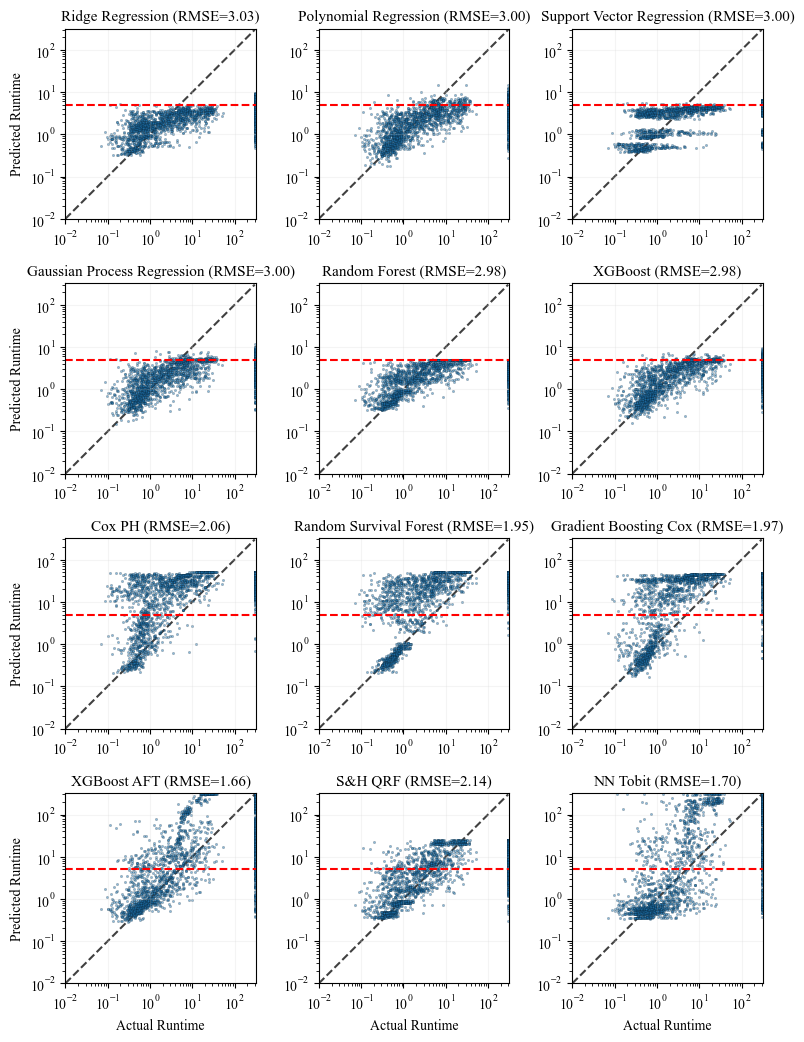

In [21]:
plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].iloc[[0, 1, 2, 3, 4, 5, 12, 13, 14, 15, 16, 17]].reset_index(drop=True)

fig, axs = plot_scatter(plot_df, const_cut_off=CONST_CUT_OFF)
# plt.savefig("fig.png", dpi=200, bbox_inches="tight")
plt.show()

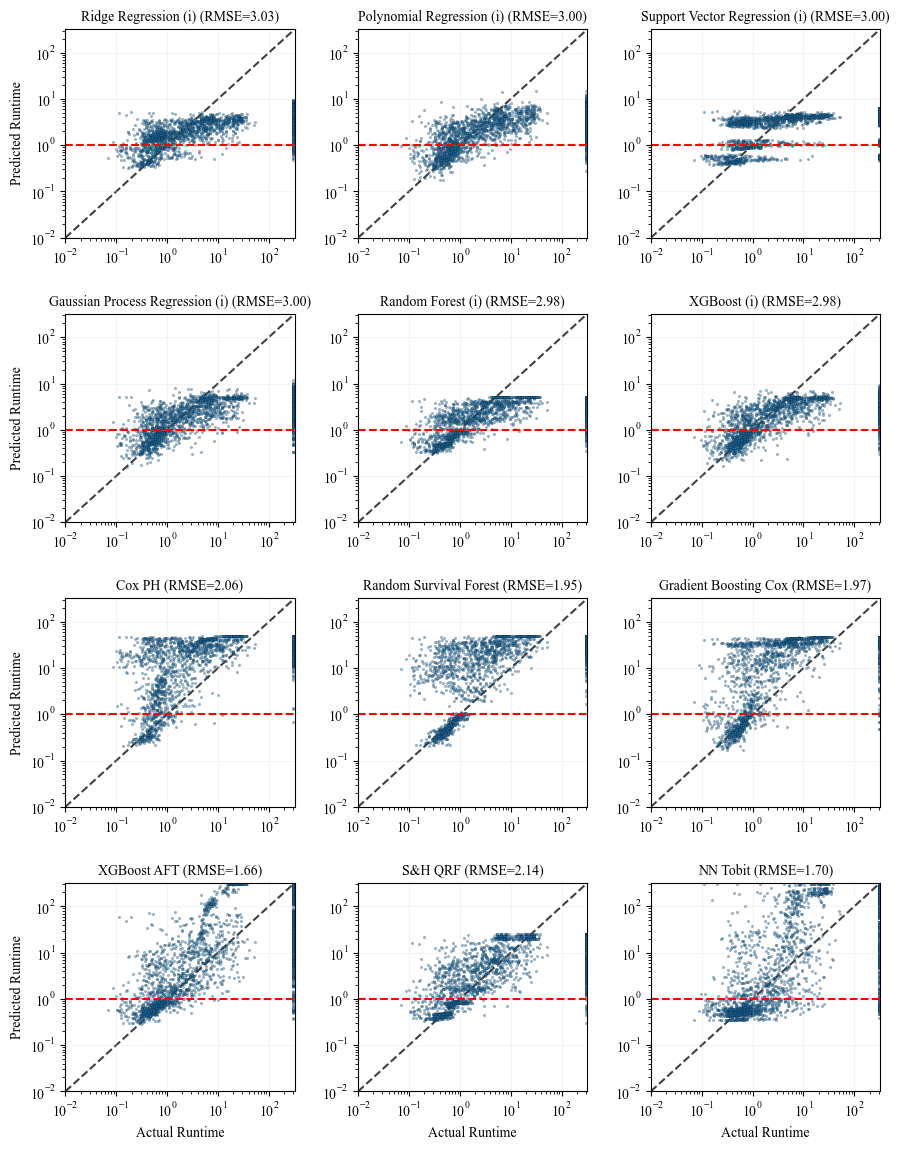

In [22]:
plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].iloc[[0, 1, 2, 3, 4, 5, 12, 13, 14, 15, 16, 17]].reset_index(drop=True)
plot_df.loc[:5, "name"] += " (i)"
const_cut_off = 1.0

n_plots = len(plot_df)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(9, 2.9 * n_rows))

if n_rows == 1:
    axs = axs.reshape(1, -1)

axs = axs.flatten()

for i, result in plot_df.iterrows():
    ax = axs[i]

    ax.scatter(
        result["y_test_not_censored"],
        result["y_pred"],
        alpha=0.5,
        edgecolors="k",
        lw=0.2,
        s=3,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(0.01, 320)
    ax.set_ylim(0.01, 320)
    ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
    ax.set_title(f'{result["name"]} (RMSE={result["rmse"]:.2f})', fontsize=10)
    if const_cut_off is not None:
        ax.axhline(y=const_cut_off, color="red", linestyle="--")

for i in range(n_plots, len(axs)):
    axs[i].set_visible(False)

for row in range(n_rows):
    left_idx = row * n_cols
    if left_idx < n_plots:
        axs[left_idx].set_ylabel("Predicted Runtime")

bottom_row_start = (n_rows - 1) * n_cols
for col in range(n_cols):
    bottom_idx = bottom_row_start + col
    if bottom_idx < n_plots:
        axs[bottom_idx].set_xlabel("Actual Runtime")

plt.tight_layout(h_pad=2, w_pad=2)
plt.savefig("fig.png", dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
fig, ax = plot_line(
    result_df.loc[
        result_df["name"].isin(
            [
                "Cox PH",
                "Random Survival Forest",
                "Gradient Boosting Cox",
                "XGBoost AFT",
                "S&H QRF",
                "NN Tobit",
            ]
        )
    ]
)

# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

In [23]:
styled_result = wilcoxon_df(result_df, model_info_list)
styled_result

solver_number,5,10,15,20,30,50,70,100,150,200,300,500
name,,,,,,,,,,,,
Ridge Regression,3.182,3.285,3.218,3.313,3.315,3.233,3.187,3.213,3.205,3.237,3.220,3.230
Polynomial Regression,3.253,3.267,3.259,3.274,3.303,3.240,3.188,3.199,3.183,3.202,3.173,3.169
Support Vector Regression,3.202,3.254,3.202,3.220,3.262,3.201,3.155,3.181,3.176,3.211,3.190,3.202
Gaussian Process Regression,3.375,3.316,3.237,3.254,3.291,3.223,3.166,3.182,3.177,3.201,3.176,3.171
Random Forest,3.464,3.369,3.265,3.291,3.288,3.212,3.145,3.160,3.153,3.178,3.154,3.153
XGBoost,3.287,3.289,3.220,3.242,3.277,3.208,3.145,3.160,3.153,3.177,3.151,3.150
Ridge Regression (skip cut-off),4.122,3.901,4.055,3.992,3.856,3.632,3.824,3.881,3.592,3.832,4.014,3.892
Polynomial Regression (skip cut-off),4.224,4.179,3.858,3.826,3.777,3.805,3.670,3.690,3.628,3.502,3.639,3.831
Support Vector Regression (skip cut-off),4.093,3.824,3.979,4.046,3.868,3.585,3.841,3.879,3.572,3.814,3.842,3.875


In [25]:
styled_result.to_excel("tmp.xlsx")

In [ ]:
idx = [x["name"] for x in model_info_list]
# fit time
result_df.pivot_table(index="name", columns="solver_number", values="fit_time", aggfunc="mean").loc[idx].style.background_gradient(cmap="coolwarm", axis=None).format(precision=2)

In [ ]:
# predict time
result_df.pivot_table(index="name", columns="solver_number", values="predict_time", aggfunc="mean").loc[idx].style.background_gradient(cmap="coolwarm", axis=None).format(precision=2)